# General Adversarial Network

In an ordinary GAN structure, there are two agents competing with each other: a Generator and a Discriminator. They may be designed using different networks (e.g. Convolutional Neural Networks (CNNs), Recurrent Neural Networks (RNNs), or just Regular Neural Networks (ANNs or RegularNets)). Since we will generate images, CNNs are better suited for the task. 

https://machinelearningmastery.com/impressive-applications-of-generative-adversarial-networks/

https://towardsdatascience.com/image-generation-in-10-minutes-with-generative-adversarial-networks-c2afc56bfa3b

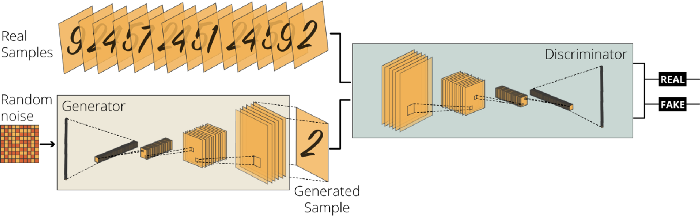

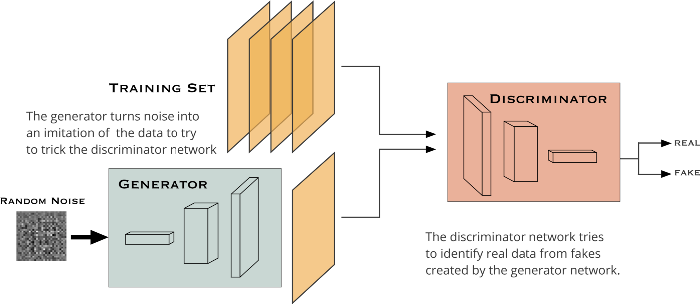

In a nutshell, we will ask the generator to generate handwritten digits without giving it any additional data. Simultaneously, we will fetch the existing handwritten digits to the discriminator and ask it to decide whether the images generated by the Generator are genuine or not. At first, the Generator will generate lousy images that will immediately be labeled as fake by the Discriminator. After getting enough feedback from the Discriminator, the Generator will learn to trick the Discriminator as a result of the decreased variation from the genuine images.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
import matplotlib.pyplot as plt

In [ ]:
# underscore to omit the label arrays
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() 

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Our generator network is responsible for generating 28x28 pixels grayscale fake images from random noise. Therefore, it needs to accept 1-dimensional arrays and output 28x28 pixels images. For this task, we need Transposed Convolution layers after reshaping our 1-dimensional array to a 2-dimensional array. Transposed Convolution layers can increase the size of a smaller array. We also take advantage of BatchNormalization and LeakyReLU layers. 

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [ ]:
generator = make_generator_model()

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

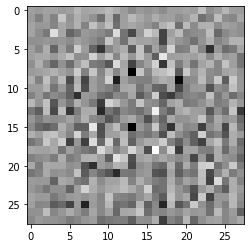

In [ ]:
# Create a random noise and generate a sample
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# Visualize the generated sample
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

For our discriminator network, we need to follow the **inverse version of our generator network**. It takes the 28x28 pixels image data and outputs a single value, representing the possibility of authenticity. So, our discriminator can review whether a sample image generated by the generator is fake.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

In [ ]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00162711]], shape=(1, 1), dtype=float32)


Since we are training two sub-networks inside a GAN network, we need to define two loss functions and two optimizers.
Loss Functions: We start by creating a Binary Crossentropy object from tf.keras.losses module. We also set the from_logits parameter to True. After creating the object, we fill them with custom discriminator and generator loss functions. Our discriminator loss is calculated as a combination of (i) the discriminator’s predictions on real images to an array of ones and (ii) its predictions on generated images to an array of zeros. Our generator loss is calculated by measuring how well it was able to trick the discriminator. Therefore, we need to compare the discriminator’s decisions on the generated images to an array of 1s.

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 60
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# tf.function annotation causes the function 
# to be "compiled" as part of the training
@tf.function
def train_step(images):
  
    # 1 - Create a random noise to feed it into the model
    # for the image generation
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # 2 - Generate images and calculate loss values
    # GradientTape method records operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # 3 - Calculate gradients using loss values and model variables
    # "gradient" method computes the gradient using 
    # operations recorded in context of this tape (gen_tape and disc_tape).
    
    # It accepts a target (e.g., gen_loss) variable and 
    # a source variable (e.g.,generator.trainable_variables)
    # target --> a list or nested structure of Tensors or Variables to be differentiated.
    # source --> a list or nested structure of Tensors or Variables.
    # target will be differentiated against elements in sources.

    # "gradient" method returns a list or nested structure of Tensors  
    # (or IndexedSlices, or None), one for each element in sources. 
    # Returned structure is the same as the structure of sources.
    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                discriminator.trainable_variables)
    
    # 4 - Process  Gradients and Run the Optimizer
    # "apply_gradients" method processes aggregated gradients. 
    # ex: optimizer.apply_gradients(zip(grads, vars))
    """
    Example use of apply_gradients:
    grads = tape.gradient(loss, vars)
    grads = tf.distribute.get_replica_context().all_reduce('sum', grads)
    # Processing aggregated gradients.
    optimizer.apply_gradients(zip(grads, vars), experimental_aggregate_gradients=False)
    """
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [ ]:
import time
from IPython import display # A command shell for interactive computing in Python.

def train(dataset, epochs):
  # A. For each epoch, do the following:
  for epoch in range(epochs):
    start = time.time()
    # 1 - For each batch of the epoch, 
    for image_batch in dataset:
      # 1.a - run the custom "train_step" function
      # we just declared above
      train_step(image_batch)

    # 2 - Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 3 - Save the model every 5 epochs as 
    # a checkpoint, which we will use later
    # if (epoch + 1) % 5 == 0:
    #  checkpoint.save(file_prefix = checkpoint_prefix)

    # 4 - Print out the completed epoch no. and the time spent
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # B. Generate a final image after the training is completed
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  # 1 - Generate images
  predictions = model(test_input, training=False)
  # 2 - Plot the generated images
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  # 3 - Save the generated images
  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

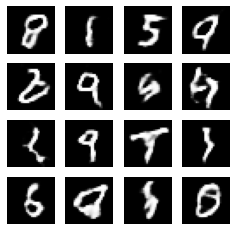

In [ ]:
train(train_dataset, EPOCHS)

# StyleGan2, CycleGan and DeepLandscape

Train on own images of landscapes to be able to generate blended, realistic images of landscapes. Use own database of day-time natural landscape pictures. May need to be specific on landscape features to generate realistic versions of each type (e.g. mountains / oceans / flatland, etc.).

https://github.com/jeffheaton/present/blob/master/youtube/gan/colab_gan_train.ipynb

https://towardsdatascience.com/how-to-train-stylegan2-ada-with-custom-dataset-dc268ff70544

https://colab.research.google.com/github/ArthurFDLR/GANightSky/blob/main/GANightSky.ipynb#scrollTo=8HX77jscX2zV

Another potential step is use of Deep Landscape to naturally animate existing landscape pictures; augment through lighting and make it feel alive. From "Instagrammable" pictures, these can be made richer and combined with StyleGan2 generation, can create an endless stream of content supplemented by a human touch.

In my opinion, the most interesting too is GauGAN, capable of generating images through text and basic contours. Tool for creatives to create photorealistic pictures limited only by their imagination.

Other interesting applications include building an app from trained models.

https://medium.com/towards-data-science/how-i-built-an-ai-text-to-art-generator-a0c0f6d6f59f


In [1]:
%tensorflow_version 1.x
!nvidia-smi

TensorFlow 1.x selected.
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



StyleGAN2-ADA only works with Tensorflow 1. Run the next cell before anything else to make sure we’re using TF1 and not TF2. **And run with GPU.**

In [2]:
from google.colab import drive
from pathlib import Path

content_path = Path('/').absolute() / 'content'
drive_path = content_path / 'drive'
drive.mount(str(drive_path))

Mounted at /content/drive


Run this cell to install StyleGAN2-ADA on your Drive. If you’ve already installed the repository, it will skip the installation process and only check for updates. Beside, in, out, datasets and training folders are generated for data storage. Everything will be available on your Google Drive in the folder StyleGAN2-ADA even after closing this Notebook.

In [3]:
stylegan2_repo_url  = 'https://github.com/dvschultz/stylegan2-ada' # or https://github.com/NVlabs/stylegan2-ada
project_path        = drive_path / 'My Drive' / 'StyleGAN2-ADA'
stylegan2_repo_path = project_path / 'stylegan2-ada'

# Create project folder if inexistant
if not project_path.is_dir():
    %mkdir "{project_path}"
%cd "{project_path}"

for dir in ['in', 'out', 'datasets', 'training']:
    if not (project_path / dir).is_dir():
        %mkdir {dir}
if not (project_path / 'datasets' / 'source').is_dir():
    %mkdir "{project_path / 'datasets' / 'source'}"

# Download StyleGAN2-ada
!git config --global user.name "MichaelMML"
!git config --global user.email "mikeml1994@gmail.com"
if stylegan2_repo_path.is_dir():
    !git -C "{stylegan2_repo_path}" fetch origin
    !git -C "{stylegan2_repo_path}" checkout origin/main -- *.py
else:
    print("Install StyleGAN2-ADA")
    !git clone {stylegan2_repo_url}

/content/drive/My Drive/StyleGAN2-ADA
Install StyleGAN2-ADA
Cloning into 'stylegan2-ada'...
remote: Enumerating objects: 364, done.
remote: Total 364 (delta 0), reused 0 (delta 0), pack-reused 364
Receiving objects: 100% (364/364), 56.17 MiB | 12.97 MiB/s, done.
Resolving deltas: 100% (197/197), done.
Checking out files: 100% (52/52), done.


In [4]:
dataset_name = 'Mountains'
datasets_source_path = project_path / 'datasets' / 'source' / (dataset_name + '.zip')
if datasets_source_path.is_dir():
    print("Dataset ready for import.")
else:
    print('Upload your images dataset as {}'.format(datasets_source_path))

Upload your images dataset as /content/drive/My Drive/StyleGAN2-ADA/datasets/source/Mountains.zip


In [ ]:
from PIL import Image
import os, sys

path = "/root/Desktop/python/images/"
dirs = os.listdir( path )

def resize():
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((200,200), Image.ANTIALIAS)
            imResize.save(f + ' resized.jpg', 'JPEG', quality=90)

resize()

Unfortunately, large datasets might exceed the Google Drive quota after a few training batches. Indeed, StyleGAN2 download datasets multiple times during training. You might have to import your dataset in the local storage session. However, large files cannot be copy/paste from Drive (Input/Output error).

Run this cell to download your zipped dataset from your Drive and unzip it in the local session.

In [ ]:
local_dataset_path = content_path / 'dataset'
if not local_dataset_path.is_dir():
    print("Importing dataset...")
    %mkdir "{local_dataset_path}"
    %cp -a "{project_path / 'datasets' / 'source' / (dataset_name + '.zip')}" "{local_dataset_path}"
    print("Zip file succesfuly imported")
else:
    print('Zip file allready imported')

import zipfile
with zipfile.ZipFile(str(local_dataset_path / (dataset_name + '.zip')), 'r') as zip_ref:
    zip_ref.extractall(str(local_dataset_path))
print('Extraction completed')

In [ ]:
local_images_path = local_dataset_path / 'images'
local_dataset_path /= 'tfr'

if (local_dataset_path).is_dir():
    print('\N{Heavy Exclamation Mark Symbol} Dataset already created \N{Heavy Exclamation Mark Symbol}')
    print('Delete current dataset folder ({}) to regenerate tfrecords.'.format(local_dataset_path))
else:
    %mkdir "{local_dataset_path}"
    !python "{stylegan2_repo_path / 'dataset_tool.py'}" create_from_images \
        "{local_dataset_path}" "{local_images_path}"

In [ ]:
from os import listdir
from os.path import isfile, join
import os
from PIL import Image
from tqdm.notebook import tqdm

IMAGE_PATH = '/content/drive/My Drive/data/gan/images/fish'
files = [f for f in listdir(IMAGE_PATH) if isfile(join(IMAGE_PATH, f))]

base_size = None
for file in tqdm(files):
    file2 = os.path.join(IMAGE_PATH,file)
    img = Image.open(file2)
    sz = img.size
    if base_size and sz!=base_size:
        print(f"Inconsistant size: {file2}")
    elif img.mode!='RGB':
        print(f"Inconsistant color format: {file2}")
    else:
        base_size = sz

There are numerous arguments to tune the training of your model. To obtain nice results, you will certainly have to experiment. Here are the most popular parameters:

mirror: Should the images be mirrored vertically?
mirrory: Should the images be mirrored horizontally?
snap: How often should the model generate image samples and a network pickle (.pkl file)?
resume: Network pickle to resume training from?
To see all the options, run the following help cell.

In [ ]:
!python "{stylegan2_repo_path / 'train.py'}" --help

In [ ]:
training_path = project_path / 'training' / dataset_name
if not training_path.is_dir():
    %mkdir "{training_path}"

#how often should the model generate samples and a .pkl file
snapshot_count = 2
#should the images be mirrored left to right?
mirrored = True
#should the images be mirrored top to bottom?
mirroredY = False
#metrics? 
metric_list = None
#augments
augs = 'bgc'

resume_from = 'ffhq1024'

!python "{stylegan2_repo_path / 'train.py'}" --outdir="{training_path}" \
    --data="{local_dataset_path}" --resume="{resume_from}" \
    --snap={snapshot_count} --augpipe={augs} \
    --mirror={mirrored} --mirrory={mirroredY} \
    --metrics={metric_list} #--dry-run

**Extra...**

In [ ]:
!pip install torch==1.8.1 torchvision==0.9.1
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja
!python /content/stylegan2-ada-pytorch/dataset_tool.py --source /content/drive/MyDrive/data/gan/images/circuit --dest /content/drive/MyDrive/data/gan/dataset/circuit

# CycleGan for Image Augmentation

E.g. switch from day to night, summer to winter and other augmentation to create further diversity. Potentially manually filter and retrain StyleGan with larger datset.

https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/CycleGAN.ipynb